In [1]:
from matplotlib import pyplot as plt
%matplotlib widget
from eitprocessing.datahandling.continuousdata import ContinuousData
from eitprocessing.datahandling.loading import load_eit_data
from eitprocessing.filters.butterworth_filters import LowPassFilter
from eitprocessing.parameters.eeli import EELI
from eitprocessing.parameters.tidal_impedance_variation import TIV
from eitprocessing.features.breath_detection import BreathDetection
MINUTE = 60

Load a sequence from file.

In [2]:
sequence = load_eit_data(
    "/Users/juliettefrancovich/Downloads/Draeger_Test_4.bin", vendor="draeger"
)

Filter the global impedance using a low pass filter.

In [3]:
gi = sequence.continuous_data["global_impedance_(raw)"]

filter_params = {
    "sample_frequency": sequence.eit_data["raw"].framerate,
    "cutoff_frequency": 50 / MINUTE,
    "order": 10,
}
filter_ = LowPassFilter(**filter_params)

sequence.continuous_data.add(
    ContinuousData(
        "global_impedance_(lowpass)",
        "Global impedance (low pass filtered)",
        "a.u.",
        "impedance",
        derived_from=[*gi.derived_from, gi],
        parameters={LowPassFilter: filter_params},
        time=gi.time,
        values=filter_.apply_filter(gi.values),
    ),
)

Filter pixel impedance

In [4]:
pixel_impedance = sequence.eit_data["raw"].pixel_impedance

In [5]:
pixel_impedance = sequence.eit_data["raw"].pixel_impedance

filter_params = {
    "sample_frequency": sequence.eit_data["raw"].framerate,
    "cutoff_frequency": 50 / MINUTE,
    "order": 10,
}
filter_ = LowPassFilter(**filter_params)


filtered_pixel_impedance = filter_.apply_filter(pixel_impedance, axis=0)

Select a small portion of the sequence

In [6]:
sequence = sequence.t[40537:40560]

Test updated breath detection for global impedance and pixel impedance

In [7]:
bd = BreathDetection(sequence.eit_data["raw"].framerate)
global_data = sequence.continuous_data["global_impedance_(raw)"].values
breaths = bd.find_breaths(global_data)

pixel_data = sequence.eit_data["raw"].pixel_impedance
breaths_array = bd.find_breaths(pixel_data)

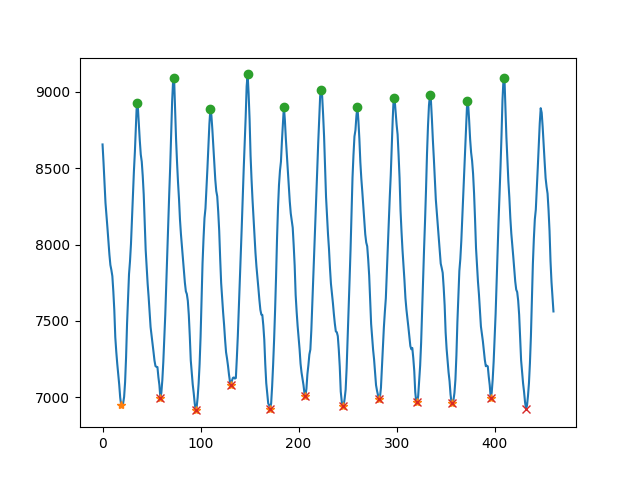

In [8]:
start_indices, middle_indices, end_indices = zip(*breaths, strict=True)
start_indices = list(start_indices)
middle_indices = list(middle_indices)
end_indices = list(end_indices)
plt.figure()
plt.plot(global_data)
plt.plot(start_indices, global_data[start_indices], "*")
plt.plot(middle_indices, global_data[middle_indices], "o")
plt.plot(end_indices, global_data[end_indices], "x")

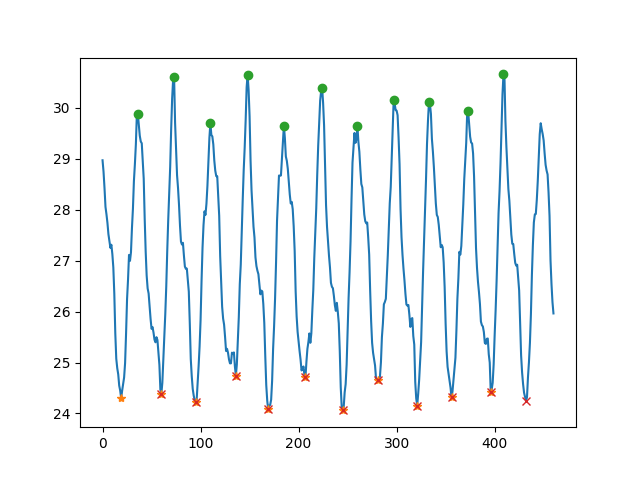

In [9]:
start_indices, middle_indices, end_indices = zip(*breaths_array[12, 13], strict=True)
plt.figure()
plt.plot(pixel_data[:, 12, 13])
plt.plot(start_indices, pixel_data[start_indices, 12, 13], "*")
plt.plot(middle_indices, pixel_data[middle_indices, 12, 13], "o")
plt.plot(end_indices, pixel_data[end_indices, 12, 13], "x")

In [10]:
tiv_result_global_inspiratory = TIV().compute_global_parameter(
    sequence, "global_impedance_(raw)"
)
tiv_result_global_expiratory = TIV().compute_global_parameter(
    sequence, "global_impedance_(raw)", tiv_method="expiratory"
)
tiv_result_global_mean = TIV().compute_global_parameter(
    sequence, "global_impedance_(raw)", tiv_method="mean"
)
tiv_result_pixel_inspiratory = TIV().compute_pixel_parameter(sequence, "raw")
tiv_result_pixel_expiratory = TIV().compute_pixel_parameter(
    sequence, "raw", tiv_method="expiratory"
)
tiv_result_pixel_mean = TIV().compute_pixel_parameter(
    sequence, "raw", tiv_method="mean"
)

In [11]:
tiv_result_global_inspiratory["values"]

array([1981.05715838, 2094.63920996, 1973.74186832, 2033.71847711,
       1977.6931278 , 2007.26267411, 1959.73824695, 1975.49553392,
       2013.48413438, 1971.42768605, 2097.70652003])

In [12]:
tiv_result_global_expiratory["values"]

array([1935.34840186, 2174.49379839, 1807.36915375, 2188.04855264,
       1896.28018317, 2072.75797019, 1914.78006076, 1995.95093779,
       2014.56585368, 1941.44418837, 2169.69074125])

In [13]:
tiv_result_global_mean["values"]

array([1958.20278012, 2134.56650417, 1890.55551103, 2110.88351487,
       1936.98665548, 2040.01032215, 1937.25915385, 1985.72323585,
       2014.02499403, 1956.43593721, 2133.69863064])

In [14]:
pixel_TIV = tiv_result_pixel_inspiratory["values"]
mean_TIV_map_inspiratory = tiv_result_pixel_inspiratory["mean"]
mean_TIV_map_expiratory = tiv_result_pixel_expiratory["mean"]
mean_TIV_map_mean = tiv_result_pixel_mean["mean"]

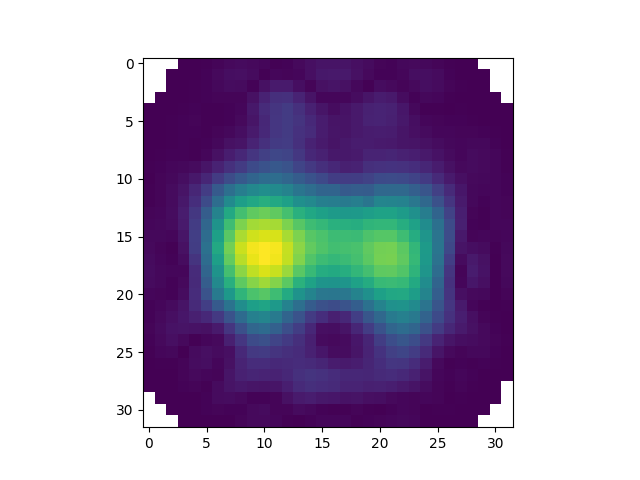

In [15]:
plt.figure()
plt.imshow(mean_TIV_map_inspiratory)

Determine the EELI of the selected portion.

In [16]:
eeli_result = EELI().compute_parameter(sequence, "global_impedance_(raw)")
eeli_result_filtered = EELI().compute_parameter(sequence, "global_impedance_(lowpass)")

Plot the results.

Note that the variation in the EELI has decreased after filtering the global impedance. The filter removed the high
frequency noise (mainly cardiac artifacts), which was causing the EELI to fluctuate. 

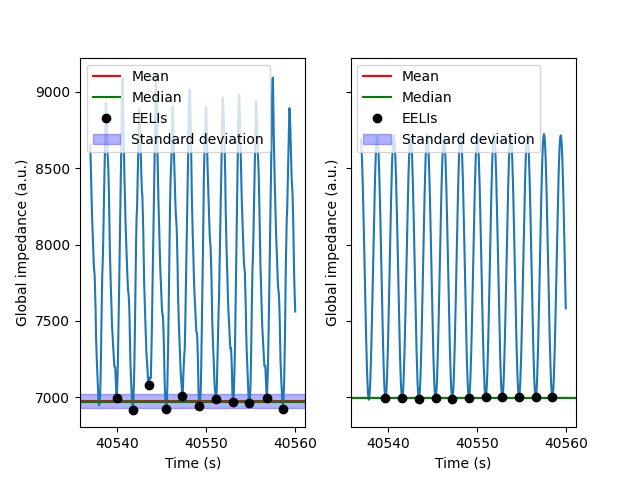

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
for ax, result, gi in zip(
    (ax1, ax2),
    (eeli_result, eeli_result_filtered),
    (
        sequence.continuous_data["global_impedance_(raw)"],
        sequence.continuous_data["global_impedance_(lowpass)"],
    ),
    strict=False,
):
    sd_upper = result["mean"] + result["standard deviation"]
    sd_lower = result["mean"] - result["standard deviation"]

    ax.plot(gi.time, gi.values)
    ax.axhline(result["mean"], color="red", label="Mean")
    ax.axhline(result["median"], color="green", label="Median")
    ax.plot(
        gi.time[result["indices"]],
        result["values"],
        "o",
        color="black",
        label="EELIs",
    )

    xlim = ax.get_xlim()
    ax.fill_between(
        xlim,
        sd_upper,
        sd_lower,
        color="blue",
        alpha=0.3,
        label="Standard deviation",
    )
    ax.set(xlim=xlim, xlabel="Time (s)", ylabel="Global impedance (a.u.)")
    ax.legend()

In [18]:
# from eitprocessing.features.moving_average import MovingAverage
# import numpy as np
# from typing import NamedTuple
# import itertools
# sample_frequency = sequence.eit_data["raw"].framerate
# minimum_distance = 2 / 3
# averaging_window_length = 15
# averaging_window_fun = np.blackman
# amplitude_cutoff_fraction = 0.25
# invalid_data_removal_window_length = 1
# invalid_data_removal_percentile = 5
# invalid_data_removal_multiplier = 4

In [19]:
# class _PeakValleyData(NamedTuple):
#     peak_indices: np.ndarray
#     peak_values: np.ndarray
#     valley_indices: np.ndarray
#     valley_values: np.ndarray

In [20]:
# class Breath(NamedTuple):
#     """Indicates the start, middle and end of a single breath."""

#     start_index: int
#     middle_index: int
#     end_index: int

In [21]:
# bd = BreathDetection(sample_frequency)

In [22]:
# _, rows, cols = data.shape
# breaths_array = np.empty((rows, cols), dtype=object)

# for row in range(rows):
#     for col in range(cols):
#         time_series = data[:, row, col]

#         window_size = int(sample_frequency * averaging_window_length)
#         averager = MovingAverage(window_size=window_size, window_fun=np.bartlett)
#         moving_average = averager.apply(time_series)

#         peak_indices, peak_values = bd._find_features(time_series, moving_average)
#         valley_indices, valley_values = bd._find_features(
#             time_series, moving_average, invert=True
#         )

#         # # Skip iteration if no peaks or valleys are detected
#         # if len(peak_indices) == 0 or len(valley_indices) == 0:
#         #     breaths_array[row, col] = []
#         #     continue

#         peak_valley_data = _PeakValleyData(
#             peak_indices,
#             peak_values,
#             valley_indices,
#             valley_values,
#         )

#         peak_valley_data = bd._remove_edge_cases(
#             *peak_valley_data, time_series, moving_average
#         )
#         peak_valley_data = bd._remove_doubles(*peak_valley_data)
#         peak_valley_data = bd._remove_low_amplitudes(*peak_valley_data)

#         breaths = [
#             Breath(int(start), int(middle), int(end))
#             for middle, (start, end) in zip(
#                 peak_valley_data.peak_indices,
#                 itertools.pairwise(peak_valley_data.valley_indices),
#                 strict=True,
#             )
#         ]

#         breaths = bd._remove_breaths_around_invalid_data(breaths, time_series)
#         breaths_array[row, col] = breaths

In [23]:
# tv = TIV()

In [24]:
# tiv_method = "inspiratory"
# rows, cols = breaths_array.shape
# tiv_values_array = np.empty((11, rows, cols), dtype=object)

# # Create a boolean mask indicating non-empty lists
# non_empty_mask = np.array([[bool(lst) for lst in row] for row in breaths_array])

# # Get the indices of non-empty lists
# non_empty_index = np.argwhere(non_empty_mask)[0]
# number_of_breaths = len(breaths_array[non_empty_index[0], non_empty_index[1]])

# for i in range(number_of_breaths):
#     for row in range(rows):
#         for col in range(cols):
#             if not breaths_array[row, col]:
#                 tiv_values_array[i, row, col] = 0
#                 continue

#             time_series = data[:, row, col]
#             start_indices, middle_indices, end_indices = zip(
#                 *breaths_array[row, col], strict=True
#             )
#             start_indices = list(start_indices)
#             middle_indices = list(middle_indices)
#             end_indices = list(end_indices)

#             if tiv_method == "inspiratory":
#                 end_inspiratory_values = time_series[middle_indices]
#                 start_inspiratory_values = time_series[start_indices]
#                 tiv_values = end_inspiratory_values - start_inspiratory_values

#             if tiv_method == "expiratory":
#                 start_expiratory_values = time_series[middle_indices]
#                 end_expiratory_values = time_series[end_indices]
#                 tiv_values = start_expiratory_values - end_expiratory_values

#             if tiv_method == "mean":
#                 start_inspiratory_values = time_series[start_indices]
#                 end_inspiratory_values = time_series[middle_indices]
#                 end_expiratory_values = time_series[end_indices]
#                 tiv_values = end_inspiratory_values - [
#                     np.mean(k)
#                     for k in zip(start_inspiratory_values, end_expiratory_values)
#                 ]

#             tiv_values_array[i, row, col] = tiv_values[i]

# tiv_values_array = tiv_values_array.astype(float)
# result = {}
# for name, function in tv.summary_stats_pixel.items():
#     result[name] = function(tiv_values_array)